In [1]:
"""
Import packages
"""
import os
import glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
print(tf.__version__)

2.2.0
Using TensorFlow backend.


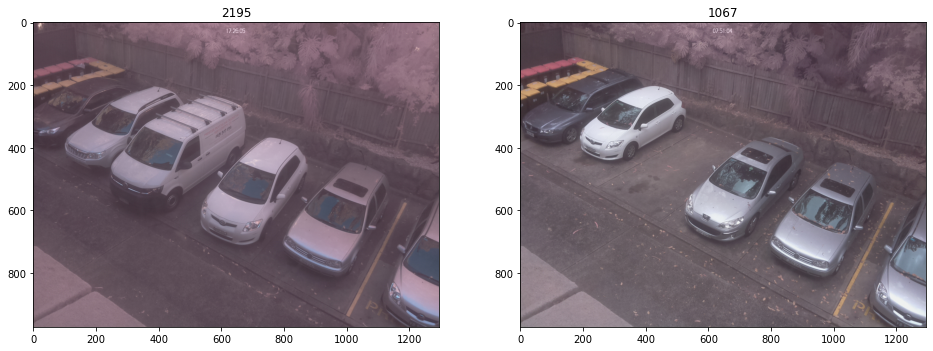

In [2]:
"""
Preview Dataset
"""
BASE_PATH = "D:/00_MLDL/02_Car_Parking/data"
FULL_LIST = glob.glob(os.path.join(BASE_PATH, "Full/*.jpg"))
FREE_LIST = glob.glob(os.path.join(BASE_PATH, "Free/*.jpg"))

full_img = img_to_array(load_img(FULL_LIST[0]), dtype=np.uint8)
free_img = img_to_array(load_img(FREE_LIST[0]), dtype=np.uint8)

plt.figure(figsize = (16, 16))
plt.subplot(1,2,1)
plt.title(len(FULL_LIST))
plt.imshow(full_img)
plt.subplot(1,2,2)
plt.title(len(FREE_LIST))
plt.imshow(free_img)
 


In [3]:
"""
Data Generator
"""

# Training data augmentation = replacing training data
# Original data itself is not used for training
# Returns only "new" data
train_datagen = ImageDataGenerator(
    rotation_range = 10, # random rotation angle range
    width_shift_range = .1,
    height_shift_range = .1,
    brightness_range=[.8, 1.2],
    shear_range=.01,
    zoom_range=[.9, 1.1], # random zoom range
    validation_split=0.1, # 90% training, 10% validation
    preprocessing_function = preprocess_input # 전처리 함수
)

# Validation data
# Using original image for model validation
# val dataset doesn't need augmentation
val_datagen = ImageDataGenerator(
    validation_split=0.1, # 90% training, 10% validation
    preprocessing_function = preprocess_input # 전처리 함수
)

# Takes the path to a directory & generates batches of augmented data
# load image from directory
train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224,224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

# Takes the path to a directory & generates batches of augmented data
# load image from directory
val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224,224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation' # (training, validation) if ImageDataGenerator has validation_split
)

# Total 3262 input images, training 2937 // validation 325
print("==============")
print(val_gen.class_indices)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


In [4]:
"""
Load Model for Transfer Learning
Pre-trained model을 가지고 내가 원하는 모델로 개조하는 작업(weght를 전이하는 작업)
"""
# include_top = False는 전이학습시 output을 내가 정의하기 위함
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
x = base_model.output
# 1D로 data flatten
x = GlobalAveragePooling2D()(x)
# 2개의 출력으로 categorize
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
# Metrics must contain 'acc', not 'accuracy'
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [5]:
"""
Switch Layers to be Trainable
모델 trainable 변수를 학습시 layer weight가 가변할 수 있도록 한다.
"""
for layer in model.layers:
    layer.trainable = True

In [11]:
"""
Train
"""
# fit_generator가 아니라 fit method를 사용
# model compile시 metrics = 'acc', monitor='val_acc'가 일치해야 model.h5 save 가능
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

Epoch 1/10
92/92 [==============================] - 1916s 21s/step - loss: 0.1592 - acc: 0.9476 - val_loss: 7.7562 - val_acc: 0.9908

Epoch 00001: val_acc improved from -inf to 0.99077, saving model to model.h5
Epoch 2/10
 4/92 [>.............................] - ETA: 43:07 - loss: 0.0806 - acc: 0.9844

In [10]:
"""
Create New Model
"""
model = load_model("model.h5")

# weights from GAP to Dense 2
last_weight = model.layers[-1].get_weights()[0] # (1280, 2)

new_model = Model(
    inputs = model.input,
    outputs = (
        model.layers[-3].output, # layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

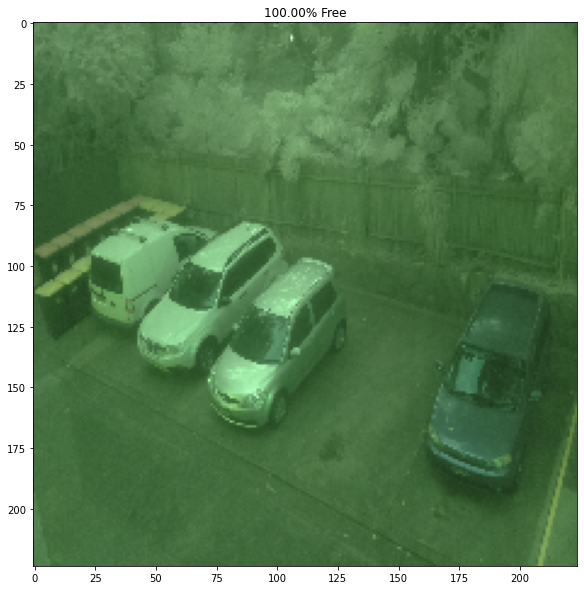

In [25]:
"""
Normal Prediction
"""
'''
Free/img_129173058.jpg
Free/img_723080007.jpg
Free/img_815061601.jpg
Full/img_127040601.jpg
Full/img_809172559.jpg
'''
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/img_815061601.jpg'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

# 10x10(inches)
plt.figure(figsize=(10, 10))
# image categorization, first index :image index, second index : full / free decision(probability)
#plt.title('%.2f %% Free' % (pred[0][1] * 100))

plt.title(f"{pred[0][1] * 100:.2f}% Free")
plt.imshow(test_img.astype(np.uint8))


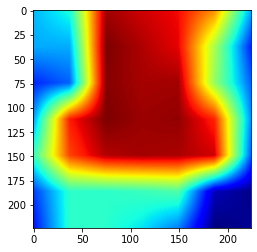

In [30]:
"""
Draw Activation Map
"""

last_conv_output, pred = new_model.predict(test_input) #(1,7,7,1280)
last_conv_output = np.squeeze(last_conv_output) # (1,7,7,1280) --> (7,7,1280)

# Zoom in by scipy.ndimage.zoom
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32,32,1), order=1) # (7,7,1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free


predicted_class_weights = last_weight[:, pred_class] #(1280, 1) only predicted model weights

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224,224)) #(224,224,1280) * (1280,1) --> (224*224,1) --> (224,224)

plt.imshow(final_output, cmap = 'jet')


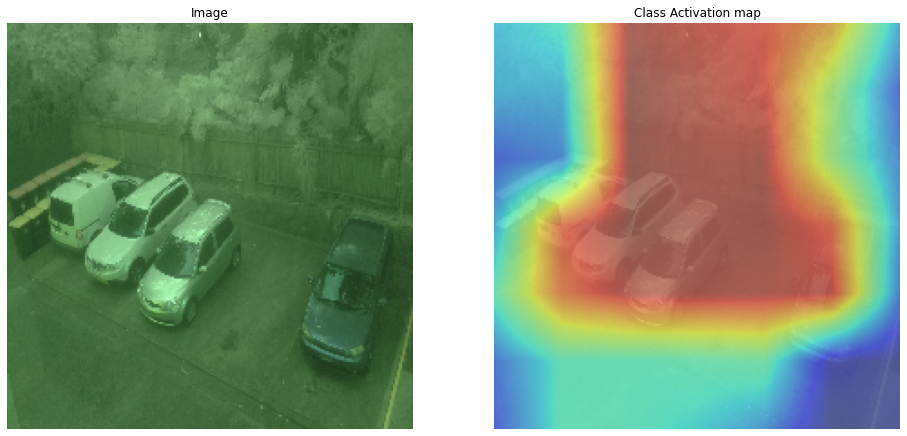

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('Class Activation map')
ax[1].axis('off')

plt.show()